In [124]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [125]:
df = pd.read_csv('C:/Users/Admin/Desktop/ANALYSE/data_science/datasets/tartu.csv')

In [126]:
df.head()

,start_time,finish_time,vehicle_start_lat,vehicle_start_lng,vehicle_dropoff_lat,vehicle_dropoff_lng,ride_value
0,2023-06-16 04:20:50,2023-06-16 04:24:31,58.390856,26.729577,58.397929,26.736289,0.81
1,2023-06-16 04:20:52,2023-06-16 04:34:55,58.353762,26.680612,58.383613,26.708371,3.09
2,2023-06-16 14:09:42,2023-06-16 14:23:30,58.381312,26.751922,58.353977,26.726323,3.04
3,2023-06-16 14:18:36,2023-06-16 14:24:04,58.373844,26.749696,58.378362,26.726674,1.20
4,2023-06-16 15:27:09,2023-06-16 15:30:30,58.345220,26.715535,58.350316,26.723769,0.74


In [127]:
df.shape

(328335, 7)

### Cleaning data

In [128]:
# filtr df and  exclude any data points with potentially erroneous coordinates outside of these ranges.
df = df[(df.vehicle_start_lat<90) & (df.vehicle_dropoff_lat<90) &
        (df.vehicle_start_lat>-90) & (df.vehicle_dropoff_lat>-90) &
        (df.vehicle_start_lng<180) & (df.vehicle_dropoff_lng<180) &
        (df.vehicle_start_lng>-180) & (df.vehicle_dropoff_lng>-180)]

In [129]:
df.shape

(328209, 7)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328209 entries, 0 to 328334
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   start_time           328209 non-null  object 
 1   finish_time          328209 non-null  object 
 2   vehicle_start_lat    328209 non-null  float64
 3   vehicle_start_lng    328209 non-null  float64
 4   vehicle_dropoff_lat  328209 non-null  float64
 5   vehicle_dropoff_lng  328209 non-null  float64
 6   ride_value           328209 non-null  float64
dtypes: float64(5), object(2)
memory usage: 20.0+ MB


In [131]:
#Change data types and create new data columns
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y/%m/%d %H:%M:%S')
df['finish_time'] = pd.to_datetime(df['finish_time'], format='%Y/%m/%d %H:%M:%S')
df['year_month_day'] = df['start_time'].dt.strftime('%Y-%m-%d')
df['year_month_day'] = pd.to_datetime(df['year_month_day'])
df['year_month'] = df['start_time'].dt.strftime('%Y-%m')

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328209 entries, 0 to 328334
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   start_time           328209 non-null  datetime64[ns]
 1   finish_time          328209 non-null  datetime64[ns]
 2   vehicle_start_lat    328209 non-null  float64       
 3   vehicle_start_lng    328209 non-null  float64       
 4   vehicle_dropoff_lat  328209 non-null  float64       
 5   vehicle_dropoff_lng  328209 non-null  float64       
 6   ride_value           328209 non-null  float64       
 7   year_month_day       328209 non-null  datetime64[ns]
 8   year_month           328209 non-null  object        
dtypes: datetime64[ns](3), float64(5), object(1)
memory usage: 25.0+ MB


In [133]:
df.isnull().sum()/len(df)

start_time             0.0
finish_time            0.0
vehicle_start_lat      0.0
vehicle_start_lng      0.0
vehicle_dropoff_lat    0.0
vehicle_dropoff_lng    0.0
ride_value             0.0
year_month_day         0.0
year_month             0.0
dtype: float64

In [134]:
df.duplicated().sum()

0

In [135]:
# create  function to calculate distance between two points given their latitude and longitude
from math import sin, cos, sqrt, atan2, radians


def distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
     # Convert latitude and longitude from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
     # Difference in longitude and latitude
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    # create formula to calculate distance
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance


data = df 


df['distance'] = df.apply(lambda row: distance(row['vehicle_start_lat'], row['vehicle_start_lng'],\
                row['vehicle_dropoff_lat'], row['vehicle_dropoff_lng']), axis=1)

df['distance'] =df['distance'].round(2)

In [136]:
#create time duration column
df['time_duration_minute'] = round((df['finish_time'] - df['start_time']).dt.total_seconds() / 60,2)

In [137]:
df.head()

,start_time,finish_time,vehicle_start_lat,vehicle_start_lng,vehicle_dropoff_lat,vehicle_dropoff_lng,ride_value,year_month_day,year_month,distance,time_duration_minute
0,2023-06-16 04:20:50,2023-06-16 04:24:31,58.390856,26.729577,58.397929,26.736289,0.81,2023-06-16,2023-06,0.88,3.68
1,2023-06-16 04:20:52,2023-06-16 04:34:55,58.353762,26.680612,58.383613,26.708371,3.09,2023-06-16,2023-06,3.69,14.05
2,2023-06-16 14:09:42,2023-06-16 14:23:30,58.381312,26.751922,58.353977,26.726323,3.04,2023-06-16,2023-06,3.39,13.80
3,2023-06-16 14:18:36,2023-06-16 14:24:04,58.373844,26.749696,58.378362,26.726674,1.20,2023-06-16,2023-06,1.43,5.47
4,2023-06-16 15:27:09,2023-06-16 15:30:30,58.345220,26.715535,58.350316,26.723769,0.74,2023-06-16,2023-06,0.74,3.35


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328209 entries, 0 to 328334
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   start_time            328209 non-null  datetime64[ns]
 1   finish_time           328209 non-null  datetime64[ns]
 2   vehicle_start_lat     328209 non-null  float64       
 3   vehicle_start_lng     328209 non-null  float64       
 4   vehicle_dropoff_lat   328209 non-null  float64       
 5   vehicle_dropoff_lng   328209 non-null  float64       
 6   ride_value            328209 non-null  float64       
 7   year_month_day        328209 non-null  datetime64[ns]
 8   year_month            328209 non-null  object        
 9   distance              328209 non-null  float64       
 10  time_duration_minute  328209 non-null  float64       
dtypes: datetime64[ns](3), float64(7), object(1)
memory usage: 30.0+ MB


In [139]:
# create  function to create  day time column
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['start_time'].dt.hour.apply(get_time_of_day)


In [140]:
# create week day column
df['weekday'] = df['start_time'].dt.day_name()

In [141]:
df.head()

,start_time,finish_time,vehicle_start_lat,vehicle_start_lng,vehicle_dropoff_lat,vehicle_dropoff_lng,ride_value,year_month_day,year_month,distance,time_duration_minute,time_of_day,weekday
0,2023-06-16 04:20:50,2023-06-16 04:24:31,58.390856,26.729577,58.397929,26.736289,0.81,2023-06-16,2023-06,0.88,3.68,night,Friday
1,2023-06-16 04:20:52,2023-06-16 04:34:55,58.353762,26.680612,58.383613,26.708371,3.09,2023-06-16,2023-06,3.69,14.05,night,Friday
2,2023-06-16 14:09:42,2023-06-16 14:23:30,58.381312,26.751922,58.353977,26.726323,3.04,2023-06-16,2023-06,3.39,13.80,afternoon,Friday
3,2023-06-16 14:18:36,2023-06-16 14:24:04,58.373844,26.749696,58.378362,26.726674,1.20,2023-06-16,2023-06,1.43,5.47,afternoon,Friday
4,2023-06-16 15:27:09,2023-06-16 15:30:30,58.345220,26.715535,58.350316,26.723769,0.74,2023-06-16,2023-06,0.74,3.35,afternoon,Friday


In [142]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vehicle_start_lat,328209.0,58.373819,0.013348,5.830053e+01,58.369561,58.376349,58.380403,58.417156
vehicle_start_lng,328209.0,26.724427,0.020864,2.664421e+01,26.712418,26.724998,26.734148,26.809626
vehicle_dropoff_lat,328209.0,58.356440,1.003470,0.000000e+00,58.369204,58.376201,58.380507,58.417113
vehicle_dropoff_lng,328209.0,26.716827,0.459852,0.000000e+00,26.712817,26.724886,26.734821,26.809342
ride_value,328209.0,1.594799,1.504789,0.000000e+00,0.770000,1.250000,1.970000,40.110000
distance,328209.0,3.261214,118.622291,0.000000e+00,0.590000,1.000000,1.620000,6905.820000
time_duration_minute,328209.0,-678.231313,138905.631071,-2.821595e+07,3.730000,5.920000,9.280000,1666.670000


In [143]:
#filtr df and exlude not appropriate values
df = df[(df['time_duration_minute'] > 0)& (df['distance'] > 0)& (df['ride_value'] > 0)]


In [144]:
df.shape

(323904, 13)

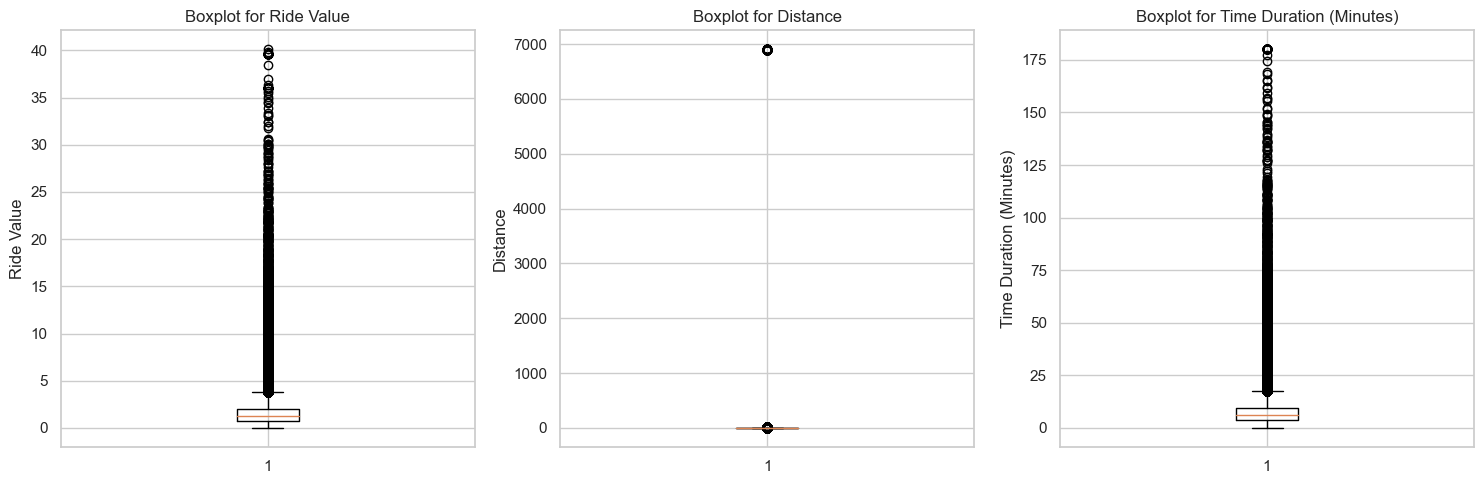

In [145]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))


axes[0].boxplot(df['ride_value'])
axes[0].set_title('Boxplot for Ride Value')
axes[0].set_ylabel('Ride Value')
axes[0].grid(True)

axes[1].boxplot(df['distance'])
axes[1].set_title('Boxplot for Distance')
axes[1].set_ylabel('Distance')
axes[1].grid(True)


axes[2].boxplot(df['time_duration_minute'])
axes[2].set_title('Boxplot for Time Duration (Minutes)')
axes[2].set_ylabel('Time Duration (Minutes)')
axes[2].grid(True)

plt.tight_layout()  
plt.show()


In [146]:
#filtr distance column and remove anomaly values
df = df[df['distance']<=50]

In [147]:
df.shape

(323815, 13)

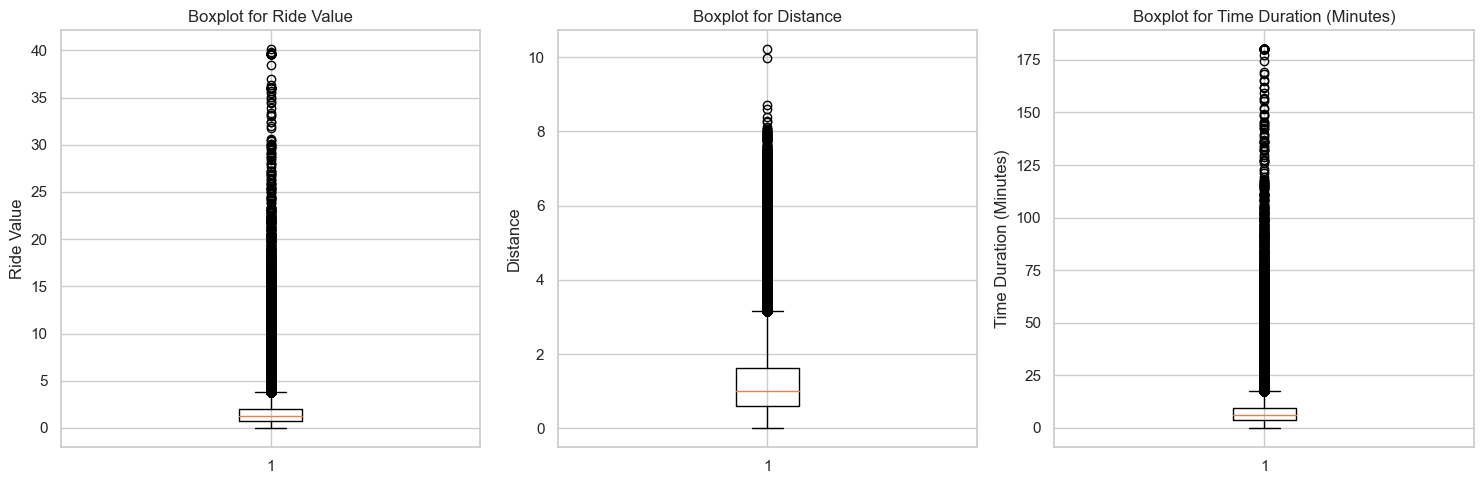

In [148]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


axes[0].boxplot(df['ride_value'])
axes[0].set_title('Boxplot for Ride Value')
axes[0].set_ylabel('Ride Value')
axes[0].grid(True)

axes[1].boxplot(df['distance'])
axes[1].set_title('Boxplot for Distance')
axes[1].set_ylabel('Distance')
axes[1].grid(True)


axes[2].boxplot(df['time_duration_minute'])
axes[2].set_title('Boxplot for Time Duration (Minutes)')
axes[2].set_ylabel('Time Duration (Minutes)')
axes[2].grid(True)

plt.tight_layout()  
plt.show()

In [149]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vehicle_start_lat,323815.0,58.373829,0.013346,58.300535,58.369572,58.376354,58.380411,58.417156
vehicle_start_lng,323815.0,26.724436,0.020865,26.644209,26.712413,26.725004,26.734160,26.809626
vehicle_dropoff_lat,323815.0,58.373702,0.013656,58.300533,58.369222,58.376209,58.380519,58.417113
vehicle_dropoff_lng,323815.0,26.724730,0.021115,26.643321,26.712833,26.724892,26.734817,26.809342
ride_value,323815.0,1.615551,1.503225,0.010000,0.790000,1.260000,1.980000,40.110000
distance,323815.0,1.220474,0.896259,0.010000,0.590000,1.000000,1.620000,10.210000
time_duration_minute,323815.0,7.549364,6.985192,0.030000,3.720000,5.920000,9.270000,180.030000


### Cluster Analysis

In [150]:
# K-means algorithm used for clustering data points into groups based on similarities.
X = df[['distance','time_duration_minute','ride_value']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
df['cluster'] = kmeans.labels_

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [151]:
count_cluster_rides = df['cluster'].value_counts().to_frame().reset_index().\
                      rename(columns= {'index':'cluster','cluster':'count_rides'})
count_cluster_rides

,cluster,count_rides
0,2,240792
1,0,80368
2,1,2655


In [152]:
df.groupby('cluster')[['distance','ride_value','time_duration_minute']].median().round(2)

,distance,ride_value,time_duration_minute
cluster,,,
0,2.23,2.59,12.12
1,0.83,9.42,43.42
2,0.80,1.01,4.73


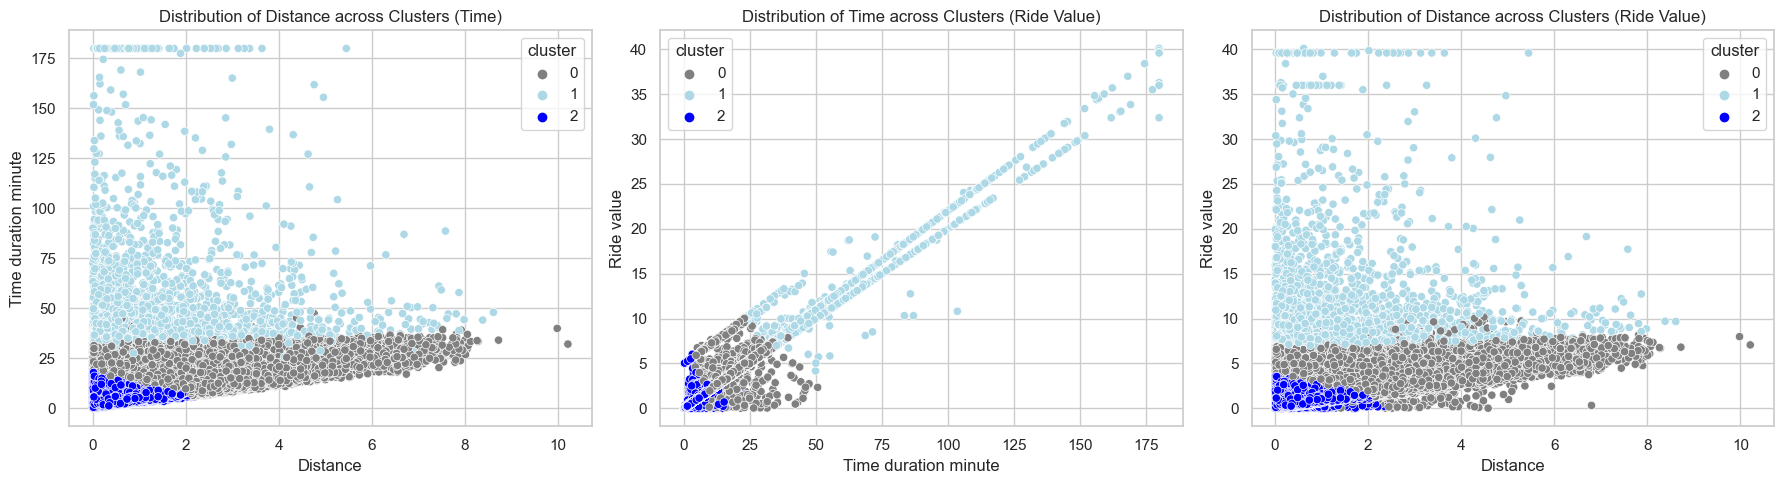

In [153]:


sns.set(style="whitegrid")


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


sns.scatterplot(x='distance', y='time_duration_minute', hue='cluster', data=df, palette=['grey', 'lightblue', 'blue'], ax=axes[0])
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Time duration minute')
axes[0].set_title('Distribution of Distance across Clusters (Time)')


sns.scatterplot(x='time_duration_minute', y='ride_value', hue='cluster', data=df, palette=['grey', 'lightblue', 'blue'], ax=axes[1])
axes[1].set_xlabel('Time duration minute')
axes[1].set_ylabel('Ride value')
axes[1].set_title('Distribution of Time across Clusters (Ride Value)')

sns.scatterplot(x='distance', y='ride_value', hue='cluster', data=df, palette=['grey', 'lightblue', 'blue'], ax=axes[2])
axes[2].set_xlabel('Distance')
axes[2].set_ylabel('Ride value')
axes[2].set_title('Distribution of Distance across Clusters (Ride Value)')

plt.tight_layout()
plt.show()


We can observe from the charts that the distance Cluster 1 rides cover doesn't depend on duration and ride values. However, all clusters indicate that distance depends on ride values. Therefore, we can infer that rides from Cluster 1 take more time and cost more not because of distance alone. We can hypothesize that the cars in this cluster are located far from the order location, necessitating more time to reach the place of order

In [154]:
all_rides_group = df.groupby('year_month')['ride_value'].count().reset_index().rename(columns={'ride_value':'total_rides'})

In [155]:
cluster_1_group = df[df['cluster']== 1].groupby('year_month')['ride_value'].count().\
                  reset_index().rename(columns={'ride_value':'cluster_1_rides'})

In [156]:
merge_group = all_rides_group.merge(cluster_1_group, how='inner', on='year_month')

In [157]:
merge_group['claster_1_ratio']=(merge_group['cluster_1_rides']/merge_group['total_rides'])

In [158]:
merge_group

,year_month,total_rides,cluster_1_rides,claster_1_ratio
0,2023-05,85255,582,0.006827
1,2023-06,84223,700,0.008311
2,2023-07,73988,689,0.009312
3,2023-08,80349,684,0.008513


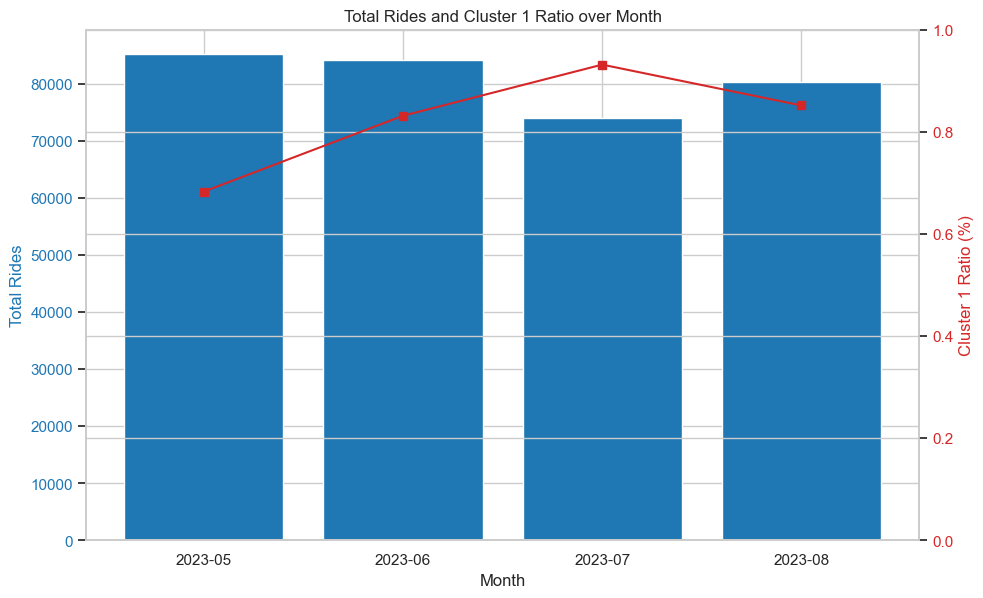

In [159]:


fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Rides', color=color)
ax1.bar(merge_group['year_month'], merge_group['total_rides'], color=color, label='Total Rides')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Cluster 1 Ratio (%)', color=color)
ax2.plot(merge_group['year_month'], merge_group['claster_1_ratio']*100, color=color, marker='s', label='Cluster 1 Ratio (%)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1)

fig.tight_layout()
plt.title('Total Rides and Cluster 1 Ratio over Month')
plt.show()


The percentage of trips where the pick-up point is far from free cars is less than 1%, and as we see in the graph, the increase in the number of trips does not affect this. This suggests that we have no problems with the number of free machines. They are just located far from the place of order.

In [160]:
group_month_day_time_cluster_1 = df[df['cluster']== 1].groupby(['year_month','time_of_day'])['ride_value'].count().\
                        reset_index().rename(columns={'ride_value':'count_rides'})

In [161]:
pivot_table_day_time_cluster_1 = group_month_day_time_cluster_1.pivot_table(index='time_of_day', \
                       columns='year_month', values='count_rides', fill_value=0)

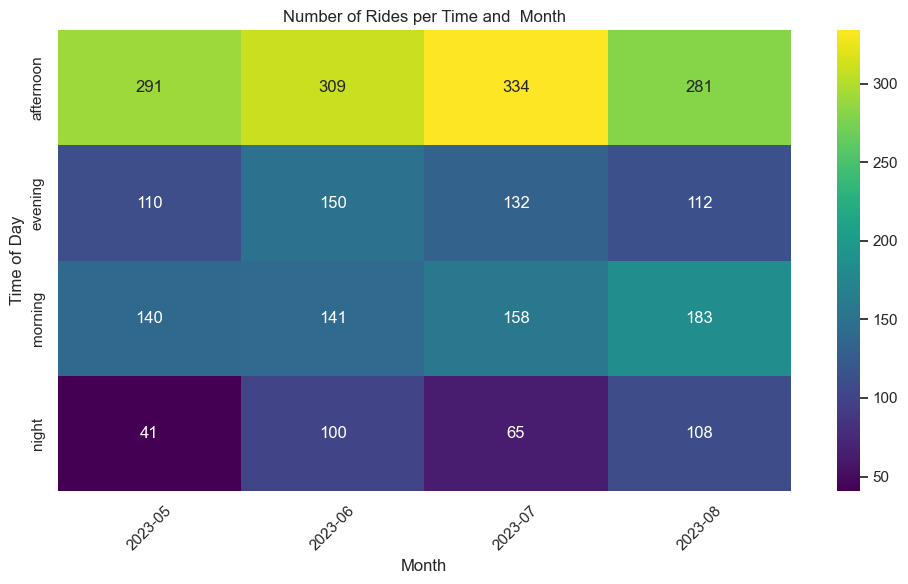

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(data=pivot_table_day_time_cluster_1, cmap='viridis', annot=True, fmt='d') 
plt.title('Number of Rides per Time and  Month')
plt.xlabel('Month')
plt.ylabel('Time of Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


On this graph you can see the effect of time of day on the number of trips of cluster 1

In [163]:
group_month_week_day_cluster_1 = df[df['cluster']== 1].groupby(['year_month','weekday'])['ride_value'].count().\
                        reset_index().rename(columns={'ride_value':'count_rides'})

In [164]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group_month_week_day_cluster_1['weekday'] = pd.Categorical(group_month_week_day_cluster_1['weekday'], categories=day_order, ordered=True)

In [165]:
pivot_table_week_day_cluster_1 = group_month_week_day_cluster_1.pivot_table(index='weekday', \
                       columns='year_month', values='count_rides', fill_value=0)

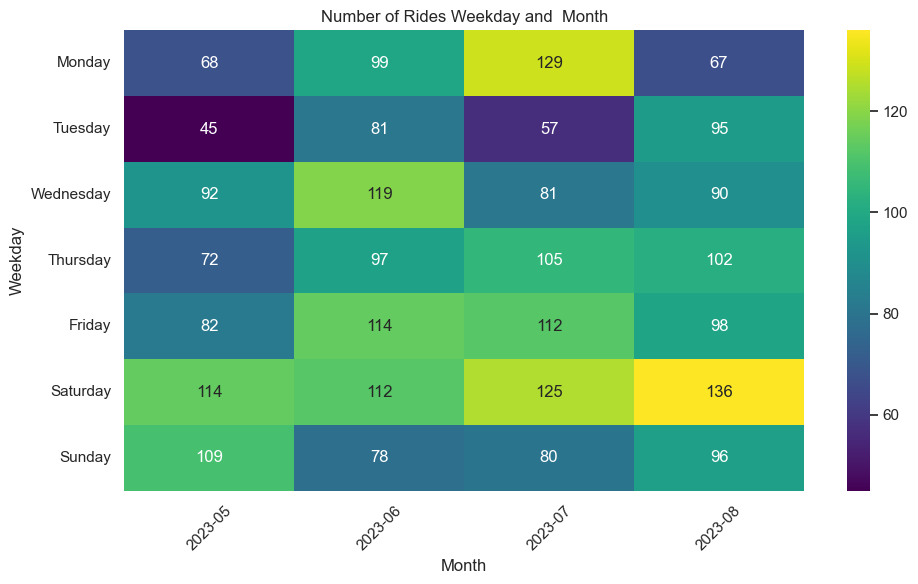

In [166]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=pivot_table_week_day_cluster_1, cmap='viridis', annot=True, fmt='d')  
plt.title('Number of Rides Weekday and  Month')
plt.xlabel('Month')
plt.ylabel('Weekday')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In this graph you can see the effect of week day on the number of trips of cluster 1

In [167]:
df.head()

,start_time,finish_time,vehicle_start_lat,vehicle_start_lng,vehicle_dropoff_lat,vehicle_dropoff_lng,ride_value,year_month_day,year_month,distance,time_duration_minute,time_of_day,weekday,cluster
0,2023-06-16 04:20:50,2023-06-16 04:24:31,58.390856,26.729577,58.397929,26.736289,0.81,2023-06-16,2023-06,0.88,3.68,night,Friday,2
1,2023-06-16 04:20:52,2023-06-16 04:34:55,58.353762,26.680612,58.383613,26.708371,3.09,2023-06-16,2023-06,3.69,14.05,night,Friday,0
2,2023-06-16 14:09:42,2023-06-16 14:23:30,58.381312,26.751922,58.353977,26.726323,3.04,2023-06-16,2023-06,3.39,13.80,afternoon,Friday,0
3,2023-06-16 14:18:36,2023-06-16 14:24:04,58.373844,26.749696,58.378362,26.726674,1.20,2023-06-16,2023-06,1.43,5.47,afternoon,Friday,2
4,2023-06-16 15:27:09,2023-06-16 15:30:30,58.345220,26.715535,58.350316,26.723769,0.74,2023-06-16,2023-06,0.74,3.35,afternoon,Friday,2


In [168]:
df[['distance','ride_value','time_duration_minute']].corr()

,distance,ride_value,time_duration_minute
distance,1.000000,0.485514,0.486924
ride_value,0.485514,1.000000,0.989006
time_duration_minute,0.486924,0.989006,1.000000


We can see strong correlation between duration and ride value. Almost 100% (98.9%) and between duration an distanse 48.6%

I decide to add weekday and day time values and check correlation.

In [169]:
weekday_dummies = pd.get_dummies(df['weekday']).astype(int)

In [170]:
daytime_dummies = pd.get_dummies(df['time_of_day']).astype(int)

In [121]:
df.columns

Index(['start_time', 'finish_time', 'vehicle_start_lat', 'vehicle_start_lng',
       'vehicle_dropoff_lat', 'vehicle_dropoff_lng', 'ride_value',
       'year_month_day', 'year_month', 'distance', 'time_duration_minute',
       'time_of_day', 'weekday', 'cluster'],
      dtype='object')

In [172]:
train_df = df.drop(columns = ['start_time', 'finish_time','year_month_day', 'vehicle_dropoff_lat', 'vehicle_dropoff_lng','year_month','time_of_day',
       'weekday', 'cluster'])

In [173]:
train_df.head()

,vehicle_start_lat,vehicle_start_lng,ride_value,distance,time_duration_minute
0,58.390856,26.729577,0.81,0.88,3.68
1,58.353762,26.680612,3.09,3.69,14.05
2,58.381312,26.751922,3.04,3.39,13.80
3,58.373844,26.749696,1.20,1.43,5.47
4,58.345220,26.715535,0.74,0.74,3.35


In [175]:
X = train_df[['ride_value', 'distance', 'time_duration_minute']]
y = train_df[['vehicle_start_lat', 'vehicle_start_lng']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0003054322356951341


In [56]:
model_df = df[['vehicle_start_lat', 'vehicle_start_lng','ride_value', 'distance', 'time_duration_minute']]



Linear Regression is a supervised learning algorithm used for modeling the relationship between a dependent variable (target) and one or more independent variables (features) by fitting a linear equation to observed data. In this case, it assumes a linear relationship between the features ('ride_value', 'distance', 'time_duration_minute') and the target variables ('vehicle_start_lat', 'vehicle_start_lng').

The model learns the coefficients for each feature, which represent the slope of the linear relationship between that feature and the target variables. Once trained, the model can make predictions by computing a weighted sum of the input features, plus a constant bias term.

Linear Regression is commonly used for tasks like prediction and forecasting, where there is a linear relationship between the input and output variables. It's a simple yet powerful algorithm, particularly when the data exhibits linear patterns.








In [60]:



X = model_df[['ride_value', 'distance', 'time_duration_minute']]
y = model_df[['vehicle_start_lat', 'vehicle_start_lng']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.0003054322356951341


The Mean Squared Error (MSE) is approximately 0.0003, which means that the model performs well in predicting the coordinates of vehicle locations on the test dataset. The closer the MSE value is to zero, the better the model. Your model accurately predicts the coordinates of vehicle locations based on the selected features.

In [59]:



X = model_df[['ride_value', 'distance', 'time_duration_minute']]
y = model_df[['vehicle_start_lat', 'vehicle_start_lng']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = xgb.XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.0003040703322494645
